In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(rasqualTools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(parallel))

In [2]:
coln = c('Feature','rsID','Chromosome','position','Ref' ,'Alt' ,'Af','HWEChi_square' ,'IA','Log10_qval','Chi_square',
        'Effect_size','Sequencing_mapping_error_rate','Ref_allele_bias' ,'Overdispersion','SNPid_within_region',
        'No_fSNPs','No_tested_SNPs','No_iterations_for_H0','No_iterations_for_H1',"ties",'Log_likelihood_H0',
        'Convergence_status','r2_fSNPs','r2_rSNP')

In [67]:
rasqual_caQTL = function(x, snp_counts, counts, offsets, covariates,  vcf=vcf_file, outdir, outlogdir,
                         nsamples=10, lead=TRUE, permut=FALSE) 
{
region  = paste0(snp_counts$chromosome_name[x], ":",snp_counts$range_start[x] ,"-",snp_counts$range_end[x])
outfile = paste0(outdir, "/",  snp_counts$gene_id[x])   
outlog    = paste0(outlogdir,"/",  snp_counts$gene_id[x], ".log")
    
system(paste("tabix",  vcf, region, "| $RASQUALDIR/bin/rasqual", 
'-y', counts,
'-k', offsets,
'-x', covariates,
"-n", nsamples,             
'-j', indexes[x] ,
'-l', snp_counts$cis_snp_count[x] ,
'-m', snp_counts$feature_snp_count[x] , 
'-s', snp_counts$exon_starts[x],
'-e', snp_counts$exon_ends[x] , 
'-f', snp_counts$gene_id[x],            
 c("","-t" )  [(lead==TRUE) +1]   ,
 c("","-r" )  [(permut==TRUE) +1]   ,
#'--min-coverage-depth 6',
'>', outfile, "2>", outlog))
    
}

In [2]:
###### set parmetes here ######
maindir     = '/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/bulk/'
celltypes   = list.files(maindir)[!grepl(".txt", list.files(maindir))]
P           =  TRUE ## permutation?  ## not necessary with the new vcf files
folder_name = 'run4_perm2_lead'
L           =  TRUE ## report only lead?
nsamples    = 10
####################################

setwd(maindir)

In [79]:
celltypes ='bulk025'

In [80]:
for (c in celltypes){

cat (c, "\n")
counts      = paste0( c, "/counts.",c, ".bin" )
offsets     = paste0( c, "/size_factors.",c, ".bin" )
#covariates  = paste0( c, "/covariates.",c, ".bin" )
covariates  = paste0( c, "/covariates2.",c, ".bin" )

inp = read.table(paste0( c, "/counts.",c, ".txt" ), row.names=1)
cm  = read.table(paste0( c,"/",c, ".count_matrix" ), header=T, stringsAsFactors = F)

peak_data = cm[,c(1,2,5,3,4)]
peak_data$Strand = as.integer(1)
colnames(peak_data) =  c('gene_id','chr','strand','exon_starts','exon_ends')
peak_data$exon_starts = as.character(peak_data$exon_starts)
peak_data$exon_ends = as.character(peak_data$exon_ends)

#vcf_dir = paste0(c, '/vcfs_peaksonly/' )
#vcf_dir = paste0(c, '/vcfs_peaks10kb/' )
 vcf_dir = paste0(c, '/vcfs_peaks50kb/' )  
    
system(paste0("bcftools query -f '%CHROM\\t%POS\\t%ID\\n' ", 
              vcf_dir,  "full.ase.filtered.vcf.gz > ",  vcf_dir, 'full.ase.filtered.snps'))
   
snps2           = read.table(paste0(vcf_dir, "full.ase.filtered.snps"))
colnames(snps2) = c('chr','pos','snp_id')
    
snp_counts2 = countSnpsOverlapingExons(peak_data, snps2, cis_window = 50000)
snp_counts2 = subset(snp_counts2, feature_snp_count>0 |  cis_snp_count> 0)
snp_counts_sub = subset(snp_counts2, gene_id %in% rownames(inp))

indexes =  match ( snp_counts_sub$gene_id,rownames(inp))

cat(sum(rownames(inp[indexes,])!= snp_counts_sub$gene_id), "\n")

sp = split(snp_counts_sub, snp_counts_sub$chromosome_name)

for ( n in 1:22){

chrom  = paste0("chr", n)
outdir = paste( c, folder_name , chrom, sep ="/")
system(paste('mkdir -p', outdir))
outlogdir = paste0(outdir, "/logs")
system(paste("mkdir",outlogdir ))
    
snp_counts_use = sp[[chrom]]
indexes        =  match ( snp_counts_use$gene_id,rownames(inp))

vcf_file = paste0(vcf_dir,  'full.ase.filtered.vcf.gz' )
    

mclapply(1:nrow(snp_counts_use), function(x) rasqual_caQTL(x, snp_counts_use, counts, offsets, covariates, 
                                                           nsamples=nsamples, 
                                                           vcf=vcf_file, outdir=outdir, outlogdir=outlogdir ,
                                                           lead=L, permut=P) , mc.cores = 16 )
         }
    
    }

bulk025 
0 


In [81]:
for (c in celltypes){
    logdir = paste0( c, "/",folder_name , "_logs")
    dir.create(logdir)
for ( n in 1:22){
        chrom  = paste0("chr", n)
        outdir = paste( c, folder_name , chrom, "logs",sep ="/")
        files = na.omit(list.files(outdir)[sapply(paste(outdir, list.files(outdir),sep="/"), file.size) >0])
 if(length(files)>0) {      
    error_files= paste(outdir, files, sep="/")
     for (err in error_files){
     system(paste("mv", err, logdir))
    }
     }
    system(paste("rm -r",outdir ))
    
            }
    
    }

In [82]:
compile_results = function(n,folder_name,outdir ){
  	    chrom  = paste0("chr", n)
        outdir = paste( c, folder_name , chrom, sep ="/")
        system(paste0("cat ", outdir,  "/* > ", c , "/", folder_name,".results_chr", n))
    }


for (c in celltypes){
    cat (c, "\n")
    tabname = paste0(c, "/Results_", folder_name, ".tsv")
    
        
 mclapply (1:22, function(x) compile_results(n=x,folder_name=folder_name,outdir=outdir))
         
        system(paste0("cat ", c , "/", folder_name,".results_chr* > ", tabname))
        system(paste0("rm ", c , "/", folder_name,".results_chr*"))
         results           = read.table(tabname, fill=T)
         colnames(results) = coln
         results           = subset(results,results$rsID !="SKIPPED")
         results$P_VAl     = pchisq(results[,11], 1, lower=F)
         write.table(results, tabname, sep="\t", quote=F)

}


bulk025 


In [48]:
# for (c in celltypes){
#     for ( n in 1:22){
#         chrom  = paste0("chr", n)
#         outdir = paste( c, folder_name , chrom, sep ="/")         
#         system(paste0("rm -r ", outdir))
        
#             }
#     system(paste0("rm -r ", c, "/", folder_name))
#  }

### Calculte empirical q-value from the permutations.
see: https://github.com/natsuhiko/rasqual/issues/21

In [86]:
# q1 : real lead Q-value vector for all peaks from RASQUAL
# q0 : permutated Q-value vector
# alpha : FDR threshold
# This function returns the P-value threshold corresponding to FDR=alpha.
getFDR <-
function(q1, q0, alpha=0.1, z=NULL, subset=NULL){
	if(is.null(z)){
		a=0
		for(itr in 1:10){
			a=getFDR(q1,q0,alpha,rev(a+0:100/100^itr),subset)
		}
		a
	}else{
		if(!is.null(subset)){
			q1=q1[subset]
			q0=q0[subset]
		}
		q1=q1[!is.na(q1)]
		q0=q0[!is.na(q0)]
		x=NULL;
		for(i in z){
			x=c(x,sum(q0<i)/length(q0)/(sum(q1<i)/length(q1)))
		};
		max(c(0,z[x<alpha]),na.rm=T)
	}
}


In [83]:
celltypes = c( "bulk025")

In [87]:
df = data.frame()
for (c in celltypes) {
results       = read.table(paste0(c, "/Results_run4_all.tsv"), header=T, stringsAsFactors = F)
random        = read.table(paste0(c, "/Results_run4_perm1_lead.tsv"), header=T, stringsAsFactors = F)
random2       = read.table(paste0(c, "/Results_run4_perm2_lead.tsv"), header=T, stringsAsFactors = F)
results       = results[order(results$P_VAl),]
results_lead  = results[!duplicated(results$Feature),]
    
thresh10      = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.1) 
thresh05       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.05) 
thresh01       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.01) 

results_lead$flag_fdr10 = 10^(results_lead$Log10_qval) < thresh10
results_lead$flag_fdr05 = 10^(results_lead$Log10_qval) < thresh05
results_lead$flag_fdr01 = 10^(results_lead$Log10_qval) < thresh01
df = rbind(df, c(thresh10, sum(results_lead$flag_fdr10, na.rm=T) , 
                   thresh05, sum(results_lead$flag_fdr05, na.rm=T),
                   thresh01, sum(results_lead$flag_fdr01, na.rm=T), nrow(results_lead)))

write.table(results_lead, paste0(c, "/Results_run4_lead.tsv"),sep="\t", quote=F, row.names=F)    

}
rownames(df) = celltypes
colnames(df) = c('pval_fdr10%', 'caQTL_fdr10%', 'pval_fdr05%', 'caQTL_fdr05%','pval_fdr01%', 'caQTL_fdr01%', "tested_features")


In [93]:
1508/184685

[1] 0.008165254

In [88]:
df

,pval_fdr10%,caQTL_fdr10%,pval_fdr05%,caQTL_fdr05%,pval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk025,0.08170918,1659,0.02582871,930,0.001260623,310,184685


In [23]:
df

,pval_fdr10%,caQTL_fdr10%,pval_fdr05%,caQTL_fdr05%,pval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk,0.05609727,4703,0.02096063,3056,0.001107148,1127,194846
bulk025,0.07140142,2503,0.03240365,1656,0.004535618,708,155652


In [91]:
mm = merge(snp_counts_sub[,c(1,8,9)], results_lead[,c('Feature', 'No_fSNPs','No_tested_SNPs')], by=1)

sum(mm[,2]==0)/nrow(mm)
sum(mm[,4]==0)/nrow(mm)


[1] 0.481241

[1] 0.4983458

In [89]:
sc = subset(results_lead, flag_fdr10==T)

In [73]:
sc = subset(res2, flag_fdr10==T)

In [90]:
inp= data.frame(SNP=unique(substring(sc$rsID,4)) , P=0.5)
dim(inp)
write.table(inp, paste0(c,"/lead_snps_run4"), quote=F, row.names=F)

[1] 1647    2

In [68]:
c

[1] "bulk025"

In [ ]:
# ### on gatsby
# plink \
# --bfile /nfs/lab/1KGP/1KGP_ALL.merged \
# --keep /nfs/lab/1KGP/1KGP.EUR.samples \
# --exclude /nfs/lab/1KGP/1KGP_ALL.merged.dupvars \
# --clump lead_snps_run4 \
# --clump-field P \
# --clump-r2 0.2 \
# --clump-kb 250 \
# --clump-p1 1 \
# --clump-p2 1 \
# --out lead_snps_run4_clumped


In [57]:
getwd()

[1] "/nfs/lab/projects/pbmc_snATAC/analysis_v2/rasqual_eur/bulk"

In [70]:
clumped = read.table( paste0(c,'/lead_snps_run3_clumped.clumped'), header=T)
dim(clumped)
sum(!duplicated(sc$Feature))
sum(!duplicated(sc$Feature[sc$rsID %in% paste0("chr", clumped$SNP)]))

[1] 1906   12

[1] 2141

[1] 1920

In [75]:
clumped = read.table( paste0(c,'/lead_snps_run2_clumped.clumped'), header=T)
dim(clumped)
sum(!duplicated(sc$Feature))
sum(!duplicated(sc$Feature[sc$rsID %in% paste0("chr", clumped$SNP)]))

[1] 2217   12

[1] 2503

[1] 2241

In [92]:
clumped = read.table( paste0(c,'/lead_snps_run4_clumped.clumped'), header=T)
dim(clumped)
sum(!duplicated(sc$Feature))
sum(!duplicated(sc$Feature[sc$rsID %in% paste0("chr", clumped$SNP)]))

[1] 1501   12

[1] 1659

[1] 1508

In [119]:
#write.table(df, "Summary_run3.txt", quote=F)

In [5]:
celltypes = c( 'b', 'mono','nk','t')

In [9]:
qqplotf = function(pvalues, title){
coaccP = sort(-log(pvalues, 10))
set.seed(1)
uniP = runif(length(coaccP))
uniP = sort(-log10(uniP))

plot(uniP, coaccP, pch=20, cex=1, xlab="Theoretical -Log10(P)", ylab="-Log10(P) caQTLs", main =title)
abline(0,1)
chisq <- qchisq(1-pvalues,1)
lgc = median(chisq)/qchisq(0.5,1)
    
    #median(qchisq(p, df=1, lower.tail=FALSE)) / qchisq(0.5, 1)
    mtext(paste("Lgc=", round(lgc,2), "MedianPval=", round(median(pvalues),3)))  
}

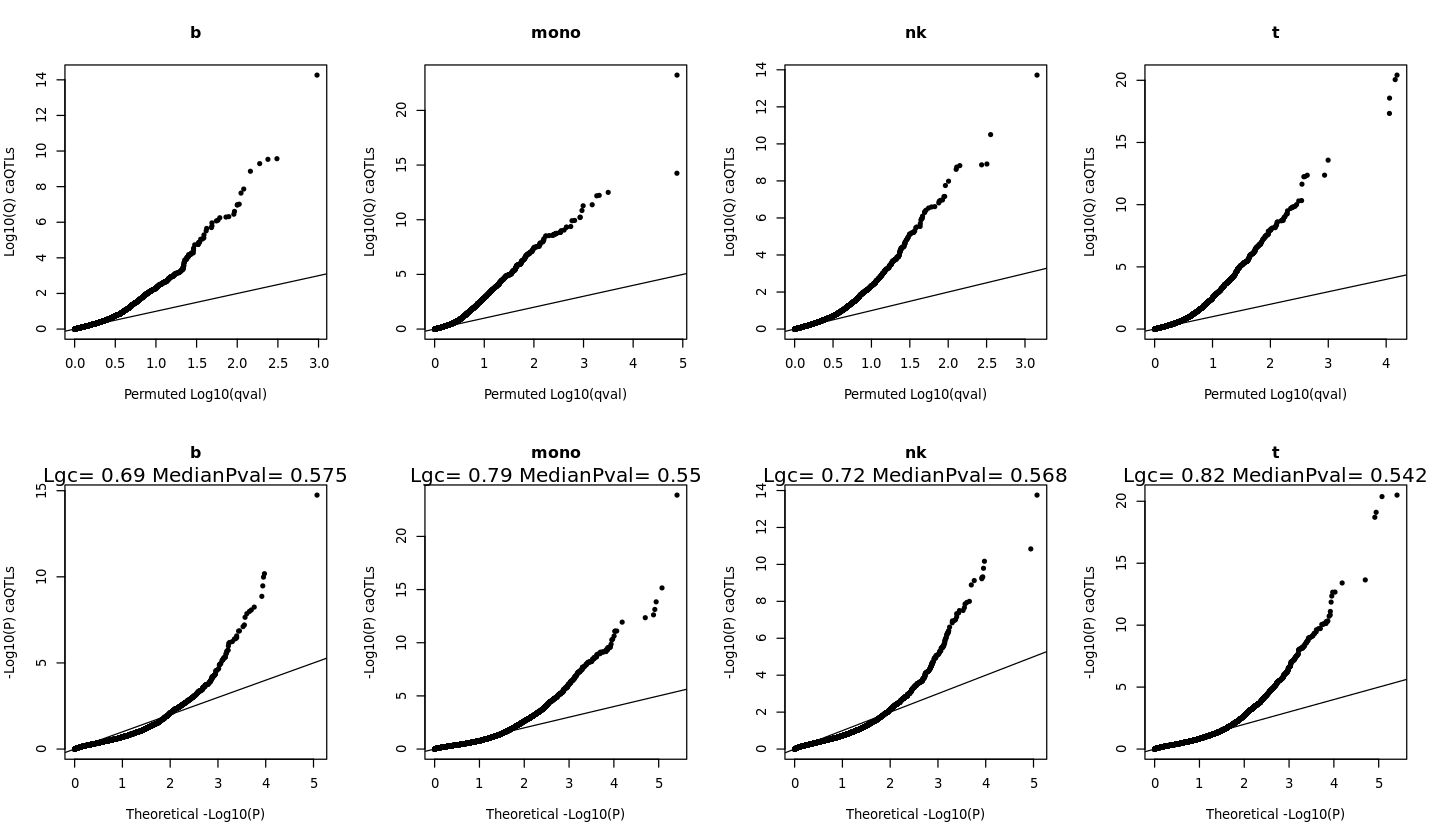

In [10]:
options(repr.plot.width=12, repr.plot.height=7)
par(mfcol=c(2,4))
for (c in celltypes) {
results_lead       = read.table(paste0(c, "/Results_run3_lead.tsv"), header=T, stringsAsFactors = F)
random             = read.table(paste0(c, "/Results_run3_perm1_lead.tsv"), header=T, stringsAsFactors = F)
 
p1 = sort(-results_lead[,10])
p2 = sort(-random[,10])
plot(p2, p1, pch=20, cex=1, xlab="Permuted Log10(qval)", ylab="Log10(Q) caQTLs", main=c)
abline(0,1)
    results_lead$cell =c
   #res= rbind(res,results_lead )
    
    qqplotf(results_lead$P_VAl, c)
    
    }

In [94]:
buori = read.table(paste0("bulk", "/Results_run3_lead.tsv"), header=T, stringsAsFactors = F)

In [95]:
busub = read.table(paste0("bulk025", "/Results_run2_lead.tsv"), header=T, stringsAsFactors = F)

In [96]:
sum(busub$flag_fdr10)

[1] 2503

In [97]:
sum(busub$Feature[busub$flag_fdr10] %in% buori$Feature[buori$flag_fdr10])

[1] 2111

In [98]:
sum(buori$flag_fdr10)

[1] 4703

In [99]:
2111/4703

[1] 0.4488624

In [100]:
2503/4703

[1] 0.5322135

In [3]:
busub50 = read.table(paste0("bulk025", "/Results_run4_lead.tsv"), header=T, stringsAsFactors = F)

In [4]:
busub10 = read.table(paste0("bulk025", "/Results_run3_lead.tsv"), header=T, stringsAsFactors = F)

In [109]:
m =merge(busub, busub50, by= "Feature", all=T)

In [114]:
table(m$flag_fdr10.x, m$flag_fdr10.y)

       
         FALSE   TRUE
  FALSE 152999    144
  TRUE     988   1508

In [115]:
table(is.na(m$flag_fdr10.x), m$flag_fdr10.y)

       
         FALSE   TRUE
  FALSE 153987   1652
  TRUE   29039      7

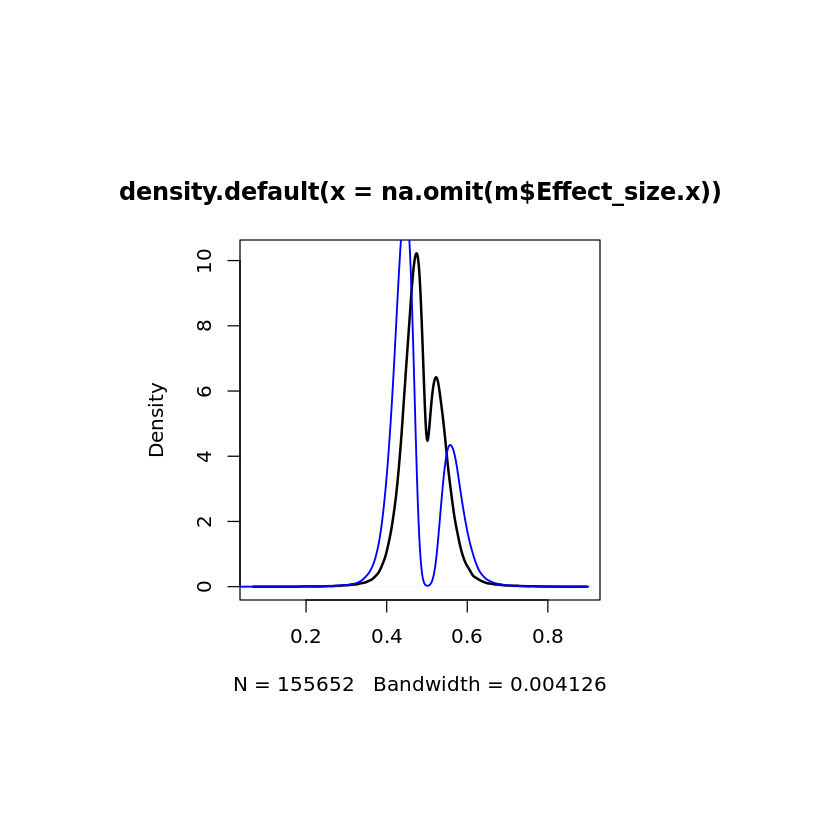

In [113]:
par(pin=c(3,3))
plot(density(na.omit(m$Effect_size.x)), lwd=2)
lines(density(na.omit(m$Effect_size.y)), lwd=1.5, col="blue")


In [117]:
distToPeak = function(RES){
bed = str_split_fixed(RES$Feature, ":|-", 3)
mid = as.numeric(bed[,2]) + ((as.numeric(bed[,3])-as.numeric(bed[,2]))/2)
tb = data.frame(midpoint = round(mid), snppsos = RES$position)
tb$dist = tb$snppsos - tb$midpoint
return(tb)
    
    }

In [118]:
tb_ori = distToPeak(busub)
tb_10 = distToPeak(busub10)
tb_50 = distToPeak(busub50)

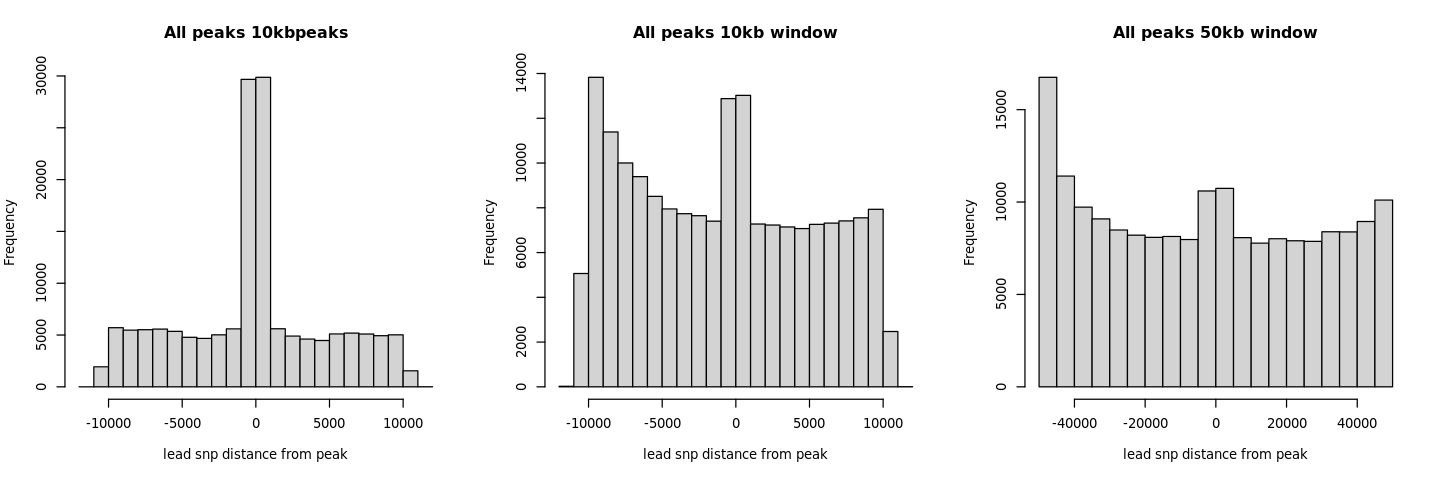

In [119]:
options(repr.plot.width=12, repr.plot.height=4)
par(mfrow=c(1,3))
hist(tb_ori$dist, xlab= "lead snp distance from peak", main = "All peaks 10kbpeaks")
hist(tb_10$dist, xlab= "lead snp distance from peak", main = "All peaks 10kb window")
hist(tb_50$dist, xlab= "lead snp distance from peak", main = "All peaks 50kb window")


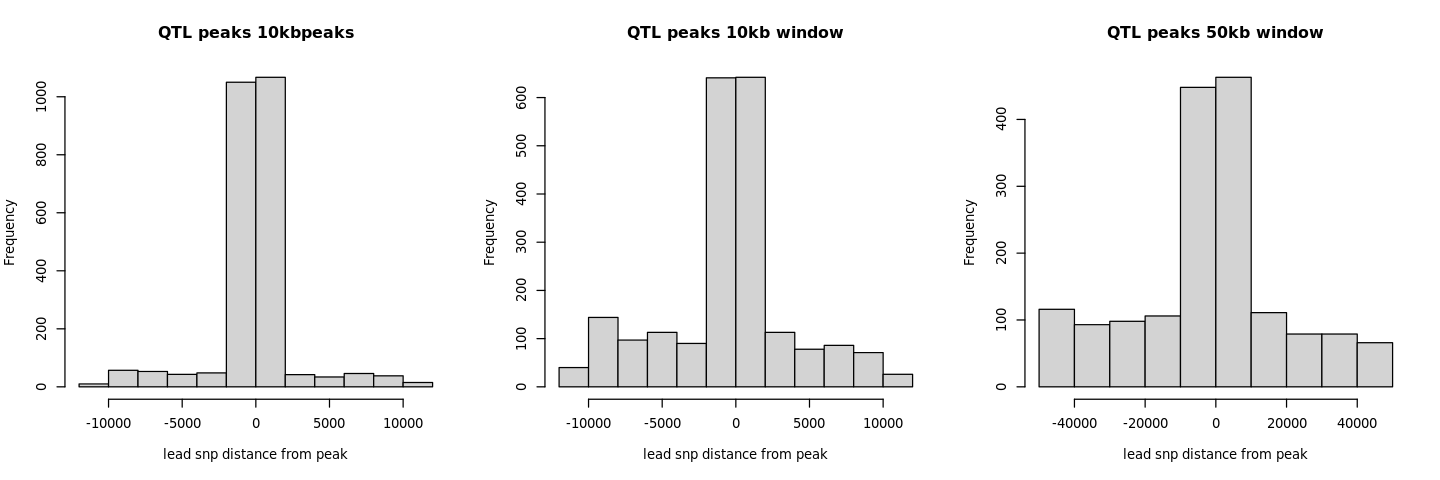

In [120]:
options(repr.plot.width=12, repr.plot.height=4)
par(mfrow=c(1,3))
hist(tb_ori$dist[busub$flag_fdr10==T], xlab= "lead snp distance from peak", main = "QTL peaks 10kbpeaks")
hist(tb_10$dist[busub10$flag_fdr10==T], xlab= "lead snp distance from peak", main = "QTL peaks 10kb window")
hist(tb_50$dist[busub50$flag_fdr10==T], xlab= "lead snp distance from peak", main = "QTL peaks 50kb window")


## QQPLOTS

In [ ]:
busub50 = read.table(paste0("bulk025", "/Results_run4_lead.tsv"), header=T, stringsAsFactors = F)
busub10 = read.table(paste0("bulk025", "/Results_run3_lead.tsv"), header=T, stringsAsFactors = F)

In [11]:
commfeat = Reduce(intersect, list(busub50$Feature,busub10$Feature))

In [13]:
busub50 = subset(busub50, Feature %in% commfeat)
busub10 = subset(busub10, Feature %in% commfeat)

In [15]:
qqplotf = function(pvalues1, pvalues2, title){
coaccP = sort(-log(pvalues1, 10))
set.seed(1)
uniP = runif(length(coaccP))
uniP = sort(-log10(uniP))

plot(uniP, coaccP, pch=20, cex=0.75, xlab="Theoretical -Log10(P)", ylab="-Log10(P) caQTLs", main =title)
abline(0,1)
chisq <- qchisq(1-pvalues1,1)
lgc = median(chisq)/qchisq(0.5,1)
    
    #median(qchisq(p, df=1, lower.tail=FALSE)) / qchisq(0.5, 1)
    mtext(paste("Lgc 50kb=", round(lgc,2)),cex = 0.8, line=-1, adj=0)  
    
 coaccP = sort(-log(pvalues2, 10))

uniP = runif(length(coaccP))
uniP = sort(-log10(uniP))

points(uniP, coaccP, pch=20, cex=0.75, col="green3")

chisq <- qchisq(1-pvalues2,1)
lgc = median(chisq)/qchisq(0.5,1)
    
    #median(qchisq(p, df=1, lower.tail=FALSE)) / qchisq(0.5, 1)
   mtext(paste("Lgc 10kb=", round(lgc,2)),cex = 0.8, col="green3", line=-2, adj=0)  
     
}

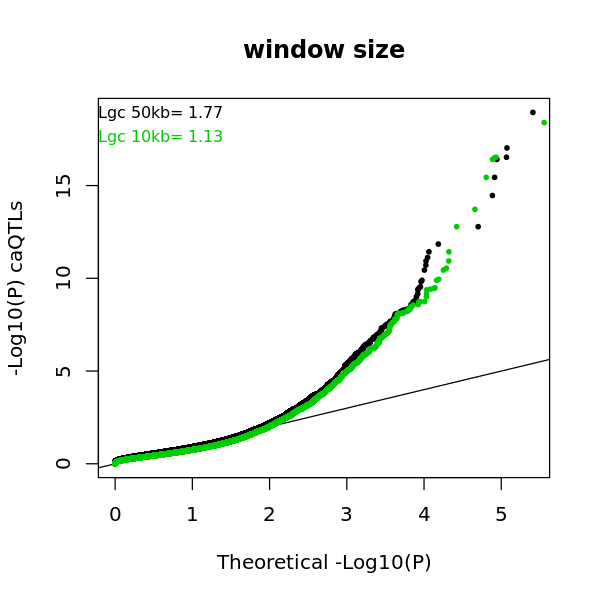

In [16]:
options(repr.plot.width=5, repr.plot.height=5)

qqplotf(busub50$P_VAl,busub10$P_VAl, "window size")


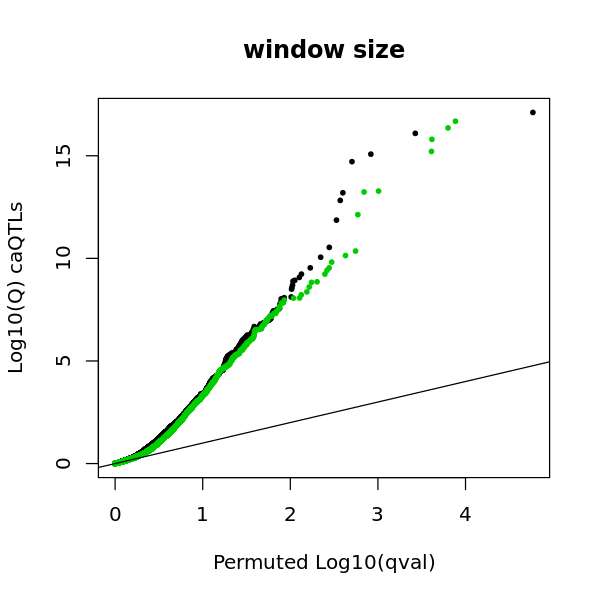

In [22]:
random50 = read.table(paste0("bulk025", "/Results_run4_perm1_lead.tsv"), header=T, stringsAsFactors = F)
random10 = read.table(paste0("bulk025", "/Results_run3_perm1.tsv"), header=T, stringsAsFactors = F)

random50 = subset(random50, Feature %in% commfeat ) 
random10 = subset(random10, Feature %in% commfeat ) 
    
  
p1 = sort(-busub50[,10])
p2 = sort(-random50[,10])                       
plot(p2, p1, pch=20, cex=0.75, xlab="Permuted Log10(qval)", ylab="Log10(Q) caQTLs", main="window size")

p1 = sort(-busub10[,10])
p2 = sort(-random10[,10])   
points(p2, p1, pch=20, cex=0.75, col="green3")

abline(0,1)
